
# Project: Investigating the TMDb Movies Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 
This dataset contains information about movies collected from the movies database, TMDb. The data provides information related to the budget, revenue, popularity, votes, directors, studios, release dates and genres of the movies among others. The dataset has information for about 10,000 movies, covering over four decades. More details about the dataset can be found at the original data page on <a href="https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata?select=tmdb_5000_movies.csv">Kaggle</a>.

### Questions
For this project, will find out what movie runtimes and movie ratings are associated with high revenue. Then will also explore how revenue from movies has changed over time and whether newer (2000s) movies are generating higher levels of revenue than older (90s) movies. Specifically, the analysis will explore the following questions:
1. Which movie runtimes are associated with high revenue?
2. What movie ratings, based on the vote average are associated with high revenue?
3. How has mean revenue from movies changed over time?

In the context of this project, the revenue used is the adjusted revenue.

In [1]:
# Importing the necessary packages for this project
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline


In [35]:
# Upgrade pandas to use dataframe.explode() function. 
#!pip install --upgrade pandas==0.25.0

<a id='wrangling'></a>
## Data Wrangling


### General Properties

In [2]:
# Load the data
movies_df = pd.read_csv('tmdb-movies.csv')

In [3]:
# Information about the columns
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10866 non-null  int64  
 1   imdb_id               10856 non-null  object 
 2   popularity            10866 non-null  float64
 3   budget                10866 non-null  int64  
 4   revenue               10866 non-null  int64  
 5   original_title        10866 non-null  object 
 6   cast                  10790 non-null  object 
 7   homepage              2936 non-null   object 
 8   director              10822 non-null  object 
 9   tagline               8042 non-null   object 
 10  keywords              9373 non-null   object 
 11  overview              10862 non-null  object 
 12  runtime               10866 non-null  int64  
 13  genres                10843 non-null  object 
 14  production_companies  9836 non-null   object 
 15  release_date       

In [38]:
# Descriptive Statistics of the data
movies_df[['runtime', 'vote_average', 'release_year', 'revenue_adj']].describe()

,runtime,vote_average,release_year,revenue_adj
count,10866.000000,10866.000000,10866.000000,1.086600e+04
mean,102.070863,5.974922,2001.322658,5.136436e+07
std,31.381405,0.935142,12.812941,1.446325e+08
min,0.000000,1.500000,1960.000000,0.000000e+00
25%,90.000000,5.400000,1995.000000,0.000000e+00
50%,99.000000,6.000000,2006.000000,0.000000e+00
75%,111.000000,6.600000,2011.000000,3.369710e+07
max,900.000000,9.200000,2015.000000,2.827124e+09


In [39]:
# Checking for duplicates
np.sum(movies_df.duplicated())

1

In [40]:
# Checking for missing values
np.sum(movies_df.isnull())

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7930
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

In [41]:
# Checking the number of movies with a positive value for budget but 0 value for revenue
movies_df.query('revenue_adj == 0 & budget_adj > 0').shape

(1315, 21)


### Data Cleaning

#### Dealing with Duplicates
For this project, I want to work with only unique movies in the data. So I will delete the duplicates.

In [42]:
# Deleting duplicates
movies_df.drop_duplicates(inplace=True)

# Confirm the deletion
movies_df.shape

(10865, 21)

#### Dealing with missing values
The `revenue_adj` column does not have any missing values. And although there are a number of movies with a positive budget but 0 value for revenue (which is unusual), I will not drop the rows for this analysis. Similarly, the other columns of interest (runtime, vote_average and release year) do not have any missing values.

#### Dealing with runtime values
The minimum value for `runtime` is 0, which shows that some movies have 0 length, which is unusual and not appropriate for this analysis. Therefore, for the analysis of `runtime`, a new dataframe will be created, which will not have values of 0 for `runtime`.

In [43]:
# Checking the number of movies with values of 0 for runtime
movies_df.query('runtime == 0').shape

(31, 21)

In [44]:
# Creating a new dataframe without values of 0 for runtime
runtime_df = movies_df.query('runtime != 0').copy()
runtime_df.shape

(10834, 21)

### New Features

#### Creating bins for runtime
The association between `runtime` and revenue will be analyzed by creating a new column with bins for different values of runtime. The new
column will have five intervals: 'Less than 60', '60 - 90', '91 - 180', '181 - 300' and 'Above 300'.

Since the analysis for movie rating also requires creating bins for different values of vote_average, will start by defining a function that creates bins so that it can be used in both cases. 

In [45]:
# Define a function that uses pandas' cut function to create bins for the given data
def create_bins(data, intervals, labels, include_lower_limit=False):
    return pd.cut(data, intervals, labels = labels, include_lowest=include_lower_limit)

In [46]:
# Create a column with bins for different values of runtime using the create_bins function
runtime_df['runtime_bins'] = create_bins(runtime_df.runtime, [0, 60, 90, 180, 300, 900], labels=['Less than 60', '60-90', '91-180', '181-300', 'Above 300'], include_lower_limit=True)
runtime_df.shape

(10834, 22)

#### Creating bins for vote_average
The association between movie rating and revenue will be analyzed by creating a new column with bins for different values of vote_average.

In [47]:
# Create a column with bins for different values of vote_average using the create_bins function
movies_df['vote_average_bins'] = create_bins(movies_df.vote_average, [0, 5, 10], labels=['0-5', '5-10'])
movies_df.shape

(10865, 22)

<a id='eda'></a>
## Exploratory Data Analysis

To ease the labeling of plots used in this section, a function that provides the title and axis labels is defined on the outset.

In [48]:
# Function for labeling charts
def set_plot_labels(plot_title, x_label, y_label, title_fontsize = 14, axis_fontsize = 13):
    plt.title(plot_title, fontsize=title_fontsize)
    plt.xlabel(x_label, fontsize=axis_fontsize)
    plt.ylabel(y_label, fontsize=axis_fontsize);

### 1. Which movie runtimes are associated with high revenues?
For this question, the runtime_df will be used.

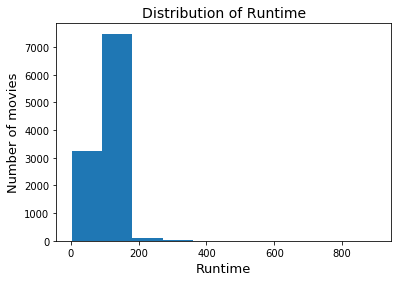

In [49]:
# What is the distribution of runtime?
plt.hist(runtime_df.runtime)
set_plot_labels('Distribution of Runtime', 'Runtime', 'Number of movies')

From the histogram above, most of the movies in the dataset are not longer than 200 minutes.

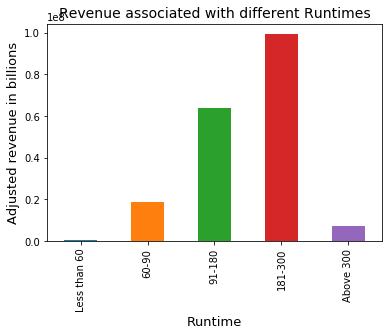

In [52]:
# What is the revenue level associated with different runtimes?
runtime_df.groupby('runtime_bins')['revenue_adj'].mean().plot(kind='bar')
set_plot_labels('Revenue associated with different Runtimes', 'Runtime', 'Adjusted revenue in billions')

From the bar chart above, it seems that movies that have runtimes in the range of 180 to 300 minutes are associated with higher revenues on average than the others.

### 2. What movie ratings, based on the vote average, are associated with high revenues?

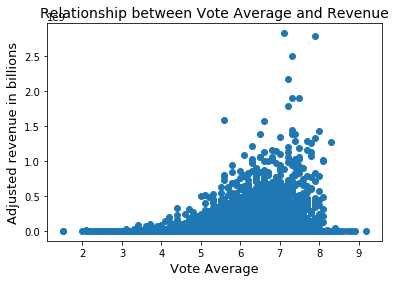

In [53]:
# Is there any type of relationship between vote average and revenue?
plt.scatter(movies_df.vote_average, movies_df.revenue_adj)
set_plot_labels('Relationship between Vote Average and Revenue', 'Vote Average', 'Adjusted revenue in billions')

From the scatter chart above, there is no clear relationship between adjusted revenue and vote average

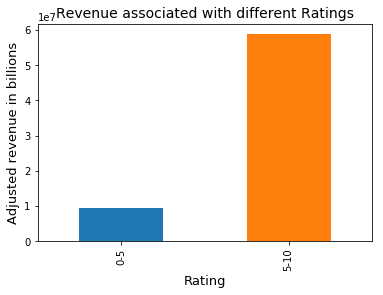

In [54]:
# What is the revenue level associated with different ratings?
movies_df.groupby('vote_average_bins')['revenue_adj'].mean().plot(kind='bar')
set_plot_labels('Revenue associated with different Ratings', 'Rating', 'Adjusted revenue in billions')

As the bar chart above shows, movies with a vote average above 5 are associated with a higher revenues , on average, than movies with a lower rating.

### 3. How has mean revenue from movies changed over time?

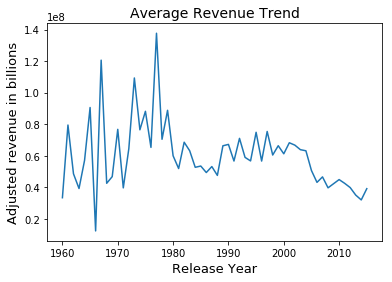

In [55]:
# Revenue trend
revenue_trend = movies_df.groupby('release_year')['revenue_adj'].mean()

# create the line chart from the revenue_trend series
plt.plot(revenue_trend.index, revenue_trend.values)
set_plot_labels('Average Revenue Trend', 'Release Year', 'Adjusted revenue in billions')

The line chart shows that on average, movie revenues plummeted in the mid 1960's before increasing in the late 1960's. Average revenues reached a peak in the 1970's but dropped in the 1980's and have been on a steady decline into the 2000's

<a id='conclusions'></a>
## Conclusions

### Summary of findings

#### 1. Which movie runtimes are associated with high revenues?
* On average, it seems that movies that have runtimes in the range of 180 minutes to 300 minutes are associated with higher revenue than shorter or longer movies.

#### 2. What movie ratings, based on the vote average, are associated with high revenues?
* On average, movies with a vote average above 5 are associated with a higher level of revenue than movies with lower ratings.

#### 3. How has the average revenue from movies changed over time?
* On average, movie revenues plummeted in the mid 1960's before reaching a peak in the 1970's but dropped in the 1980's and have been on a steady decline into the 2000's.

### Limitations
* In this analysis, an assumption was made that runtime is in minutes although it is not explicitly stated any where in the dataset-related documentation. This is a limitation because it is also possible that some of the runtime values would have been in hours (for example, the really small values) or seconds (for example, the really large values).
* It is not clear whether all the revenue values in the dataset are in the same currency, which would make the comparisons across different variables difficult. Nonetheless, this analysis assumes that all the revenue values are in the same currency.

### Further research
Since most of the movies that have runtimes in the range of 180 minutes to 300 minutes seem to be associated with higher revenues on average, it would be interesting to investigate what genres make up most of the movies in this range. Similarly, further investigation can be conducted on what genres attract better ratings and thus associated with higher levels of revenue as per the findings in the second question.